<a href="https://colab.research.google.com/github/algit123/Automated-Hyperparameter-Tuning/blob/master/Automated_Hyperparameter_Tuning_using_Bayesian_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Hyperparameter Tuning using Bayesian Optimization 

In this notebook, we use Bayesian Optimization to automatically tune hyperparameters for 2 popular Machine Learnng packages:
* Xgboost, the top gradient boosting package, and
* SVR (Support Vector Regressor) part of SVM, the Support Vector Machine family

**Data:**               We will use the 'Diabetes' dataset that is included in the sklearn package

**Scoring:**             MSE (Mean square Error) is the metric we have chosen

**Validation strategy:** We will use Cross-validation, to estimate the accuracy of our models

**Performance Gain:**    Upon Tuning, we will compute the performance gain as follows: Perforance Gain = (Baseline score(no tuning) / Achieved score) * 100. So if Baseline MSE is 100 and we achieve an MSE of 50, we would have obtained a 100% performance gain over the baseline (no tuning, default parameter values)



In [0]:
! pip install GPy gpyopt xgboost

## Import Packages 

In [0]:
import numpy as np
import GPy
import GPyOpt
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.svm import SVR
import sklearn.datasets
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import time
%matplotlib inline

## Package versions

In [11]:
for p in [np, GPy, GPyOpt, sklearn, xgboost, matplotlib]:
    print (p.__name__, p.__version__)

numpy 1.17.5
GPy 1.9.9
GPyOpt 1.2.5
sklearn 0.22.1
xgboost 0.90
matplotlib 3.1.3


## Load Data

In [0]:
dataset = sklearn.datasets.load_diabetes()
X = dataset['data']
y = dataset['target']

## 1- Xgboost

Parameters tuned:
*  max_depth, 
* learning_rate,
* n_estimators,
* min_child_weight, and
* gamma

In [0]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        XGBRegressor(learning_rate=parameters[0],
                     max_depth=int(parameters[2]),
                     n_estimators=int(parameters[3]),
                     gamma=int(parameters[1]),
                     min_child_weight = parameters[4]), 
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score

In [6]:
baseline = -cross_val_score(
    XGBRegressor(), X, y, scoring='neg_mean_squared_error'
).mean()
baseline

"\nbaseline = -cross_val_score(\n    XGBRegressor(), X, y, scoring='neg_mean_squared_error'\n).mean()\nbaseline\n"

In [0]:
# Bounds (NOTE: define continuous variables first, then discrete!)
bounds = [
    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0, 1)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (0, 5)},

    {'name': 'max_depth',
     'type': 'discrete',
     'domain': (1, 50)},

    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': (1, 300)},

    {'name': 'min_child_weight',
     'type': 'discrete',
     'domain': (1, 10)}
]

In [2]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)


"np.random.seed(777)\noptimizer = GPyOpt.methods.BayesianOptimization(\n    f=f, domain=bounds,\n    acquisition_type ='MPI',\n    acquisition_par = 0.1,\n    exact_eval=True\n)\n"

In [4]:

max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)


'\nmax_iter = 50\nmax_time = 60\noptimizer.run_optimization(max_iter, max_time)\n'

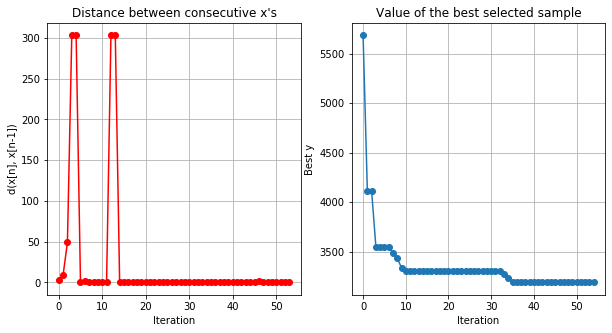

In [18]:
optimizer.plot_convergence()

Best values of parameters:

In [19]:
optimizer.X[np.argmin(optimizer.Y)]

array([4.76325090e-02, 1.19202751e+00, 1.00000000e+00, 3.00000000e+02,
       1.00000000e+00])

In [20]:
print('MSE:', np.min(optimizer.Y),
      'Gain:', baseline/np.min(optimizer.Y)*100)

MSE: 3189.185708011576 Gain: 107.77278973061391


**Result:**   We obtained a 7.7% performance gain over the baseline (default parameter values, and no tuning)

## 2- SVR (Support Vector Regressor)

Parameters tuned:
* C, 
* epsilon, and
* gamma

In [0]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        SVR(C=parameters[0],
            epsilon=float(parameters[1]),
            gamma=float(parameters[2])), 
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score

In [22]:
baseline = -cross_val_score(
    SVR(), X, y, scoring='neg_mean_squared_error'
).mean()
baseline

4976.655882526393

In [0]:
# Bounds (NOTE: define continuous variables first, then discrete!)
bounds = [
    {'name': 'C',
     'type': 'continuous',
     'domain': (1e-5, 1000)},

    {'name': 'epsilon',
     'type': 'continuous',
     'domain': (1e-5, 10)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (1e-5, 10)}
]

In [0]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

In [0]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

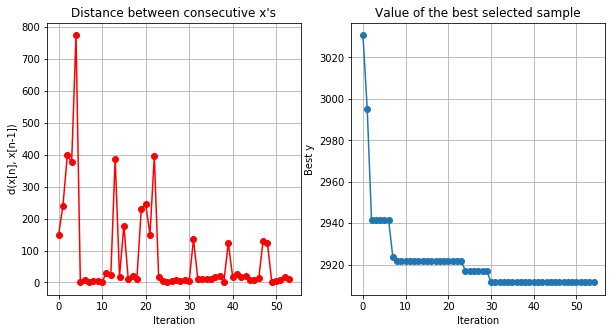

In [26]:
optimizer.plot_convergence()

Best value of parameters

In [27]:
### Best value of parameters
optimizer.X[np.argmin(optimizer.Y)]

array([37.6645348, 10.       ,  8.8905192])

In [28]:
print('MSE:', np.min(optimizer.Y),
      'Gain:', baseline/np.min(optimizer.Y)*100)

MSE: 2911.470304239638 Gain: 170.9327371561875


**Result:**  We achieved a 70.9% gain over the baseline (default parameter values and no tuning)